# Results of TSD, DANN, SCADANN models across 3 wearing locations 

Library used can be downloaded from https://github.com/aonai/long_term_EMG_myo   
&emsp; Original by UlysseCoteAllard https://github.com/UlysseCoteAllard/LongTermEMG   
Dataset recorded by https://github.com/Suguru55/Wearable_Sensor_Long-term_sEMG_Dataset   
Extended robot project can be found in https://github.com/aonai/myo_robot_arm

### Notes
* weights for TSD are total of 15 training models, 3 for each subject
* weights for DANN and SCADANN are total of 10 trianing models, 2 for each subject 


* training examples should have shape (5, 3, 40, 572, 252)
* training labels should have shape (5, 3, 40, 572)


* location 0, 1, and 2 corresponds to neutral position, inward rotation, and outward rotation respectively
* session mentioned below is wearing location, so number of sessions is 3



In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

# 0. Prepare Data

### specify the directories used for running the code:
* `code_diar`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [2]:
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
os.chdir(code_dir)
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_across_loc"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_loc/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_loc/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_loc/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (5, 3, 40, 572, 252)
traning labels  (5, 3, 40, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each linear layer (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal; i.e. size of one training example 
    * 252 for TSD
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                       
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]              
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                    
learning_rate=0.002515

number_of_cycles_total  40


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using a base model (TSD or ConvNet)
    * running this function will save num_sessions sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [8]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [9]:
algo_name = "standard_TSD"
test_standard_model_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.698776,0.751923,0.598601,0.732343,0.672203
Loc_2,0.650699,0.770105,0.540909,0.643706,0.567133


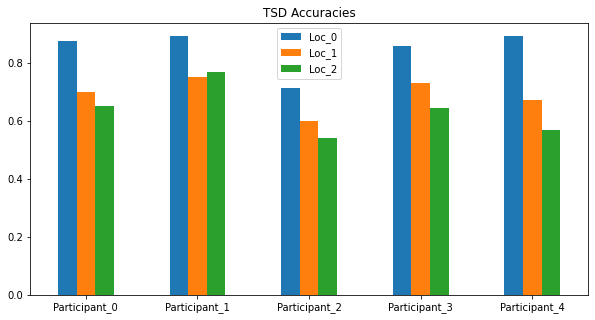

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [13]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 3)
predictions =  (5, 3)
index_participant_list  [-1, 0, 1, 2]
accuracies_gestures =  (22, 15)


,Unnamed: 0,Sub0_Loc-1,Sub0_Loc0,Sub0_Loc1,Sub1_Loc-1,Sub1_Loc0,Sub1_Loc1,Sub2_Loc-1,Sub2_Loc0,Sub2_Loc1,Sub3_Loc-1,Sub3_Loc0,Sub3_Loc1,Sub4_Loc-1,Sub4_Loc0,Sub4_Loc1
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.980769,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.973077,0.780769,0.907692,0.976923,0.953846,0.903846,0.342308,0.088462,0.700000,0.803846,0.846154,0.423077,0.961538,0.788462,0.542308
2,M2,0.707692,0.415385,0.550000,0.969231,0.880769,0.988462,0.515385,0.461538,0.246154,0.892308,0.476923,0.803846,0.915385,0.873077,0.561538
3,M3,0.919231,0.469231,0.996154,1.000000,0.950000,0.984615,0.830769,0.723077,0.550000,0.865385,0.346154,0.903846,0.946154,0.542308,0.669231
4,M4,0.865385,0.907692,0.430769,1.000000,0.996154,0.492308,0.819231,0.334615,0.426923,0.830769,0.803846,0.496154,0.853846,0.353846,0.226923
5,M5,0.953846,0.646154,0.753846,1.000000,0.992308,0.953846,0.865385,0.984615,0.292308,0.980769,0.957692,0.665385,0.976923,0.684615,0.546154
6,M6,0.992308,0.707692,0.726923,0.826923,0.896154,0.726923,0.926923,0.838462,0.803846,0.942308,0.884615,0.853846,0.961538,0.776923,0.596154
7,M7,0.926923,0.630769,0.611538,0.969231,0.600000,0.684615,0.584615,0.746154,0.284615,0.934615,0.373077,0.603846,0.915385,0.623077,0.396154
8,M8,1.000000,0.973077,0.723077,0.823077,0.946154,0.703846,0.826923,0.876923,0.511538,0.773077,0.600000,0.192308,0.861538,0.680769,0.488462
9,M9,1.000000,0.750000,0.769231,0.950000,0.823077,0.530769,0.803846,0.696154,0.842308,0.888462,0.803846,0.442308,0.757692,0.557692,0.550000


# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [14]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [15]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

In [16]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

In [17]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.694755,0.870804,0.676573,0.764685,0.73986
Loc_2,0.714161,0.873252,0.601923,0.690385,0.593706


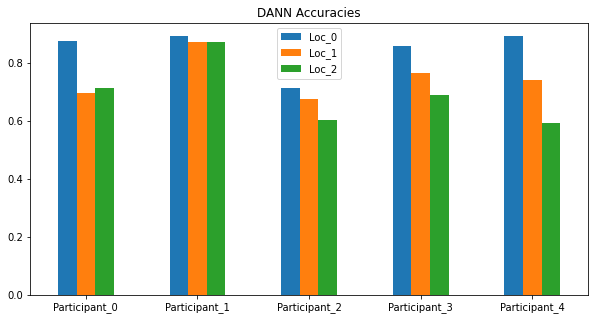

In [18]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

In [19]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_DANN, algo_name=algo_name)
df = pd.read_csv(save_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 3)
predictions =  (5, 3)
index_participant_list  [-1, 0, 1, 2]
accuracies_gestures =  (22, 15)


,Unnamed: 0,Sub0_Loc-1,Sub0_Loc0,Sub0_Loc1,Sub1_Loc-1,Sub1_Loc0,Sub1_Loc1,Sub2_Loc-1,Sub2_Loc0,Sub2_Loc1,Sub3_Loc-1,Sub3_Loc0,Sub3_Loc1,Sub4_Loc-1,Sub4_Loc0,Sub4_Loc1
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.957692,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.973077,0.703846,0.753846,0.976923,0.873077,0.965385,0.342308,0.576923,0.661538,0.803846,0.711538,0.580769,0.961538,0.780769,0.576923
2,M2,0.707692,0.469231,0.876923,0.969231,0.957692,0.830769,0.515385,0.876923,0.442308,0.892308,0.592308,0.896154,0.915385,0.911538,0.511538
3,M3,0.919231,0.496154,0.992308,1.000000,0.953846,0.969231,0.830769,0.792308,0.953846,0.865385,0.469231,0.942308,0.946154,0.703846,0.742308
4,M4,0.865385,0.742308,0.257692,1.000000,0.973077,0.784615,0.819231,0.465385,0.519231,0.830769,0.761538,0.634615,0.853846,0.507692,0.415385
5,M5,0.953846,0.561538,0.915385,1.000000,0.900000,0.734615,0.865385,0.984615,0.842308,0.980769,0.942308,0.842308,0.976923,0.838462,0.607692
6,M6,0.992308,0.619231,0.715385,0.826923,0.992308,0.750000,0.926923,0.796154,0.776923,0.942308,0.919231,0.850000,0.961538,0.938462,0.673077
7,M7,0.926923,0.650000,0.473077,0.969231,0.773077,0.503846,0.584615,0.961538,0.130769,0.934615,0.592308,0.446154,0.915385,0.757692,0.365385
8,M8,1.000000,0.930769,0.930769,0.823077,1.000000,0.923077,0.826923,0.715385,0.542308,0.773077,0.692308,0.430769,0.861538,0.653846,0.465385
9,M9,1.000000,0.838462,0.846154,0.950000,0.988462,1.000000,0.803846,0.326923,0.603846,0.888462,0.838462,0.546154,0.757692,0.692308,0.642308


# 3. SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [20]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import \
    run_SCADANN_training_sessions, test_network_SCADANN

In [21]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [22]:
algo_name = "SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

In [23]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.73479,0.899301,0.697028,0.783916,0.780944
Loc_2,0.751399,0.906818,0.636189,0.74965,0.615734


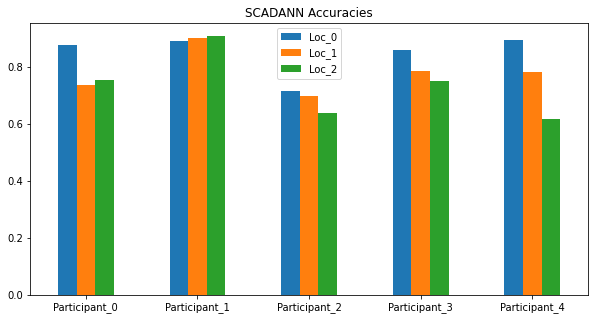

In [24]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

In [25]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_SCADANN, algo_name=algo_name)
df = pd.read_csv(save_SCADANN+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 3)
predictions =  (5, 3)
index_participant_list  [-1, 0, 1, 2]
accuracies_gestures =  (22, 15)


,Unnamed: 0,Sub0_Loc-1,Sub0_Loc0,Sub0_Loc1,Sub1_Loc-1,Sub1_Loc0,Sub1_Loc1,Sub2_Loc-1,Sub2_Loc0,Sub2_Loc1,Sub3_Loc-1,Sub3_Loc0,Sub3_Loc1,Sub4_Loc-1,Sub4_Loc0,Sub4_Loc1
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.957692,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.973077,0.780769,0.850000,0.976923,0.903846,1.000000,0.342308,0.657692,0.611538,0.803846,0.742308,0.788462,0.961538,0.873077,0.569231
2,M2,0.707692,0.415385,0.953846,0.969231,0.973077,0.857692,0.515385,1.000000,0.623077,0.892308,0.584615,0.915385,0.915385,0.973077,0.550000
3,M3,0.919231,0.519231,0.996154,1.000000,0.969231,0.992308,0.830769,0.865385,0.980769,0.865385,0.503846,0.950000,0.946154,0.684615,0.800000
4,M4,0.865385,0.815385,0.242308,1.000000,1.000000,0.900000,0.819231,0.561538,0.569231,0.830769,0.838462,0.750000,0.853846,0.592308,0.473077
5,M5,0.953846,0.588462,0.969231,1.000000,0.957692,0.711538,0.865385,0.980769,0.946154,0.980769,0.996154,0.915385,0.976923,0.930769,0.703846
6,M6,0.992308,0.615385,0.876923,0.826923,0.996154,0.776923,0.926923,0.869231,0.769231,0.942308,0.934615,0.880769,0.961538,0.992308,0.761538
7,M7,0.926923,0.696154,0.584615,0.969231,0.776923,0.565385,0.584615,0.973077,0.034615,0.934615,0.634615,0.342308,0.915385,0.838462,0.350000
8,M8,1.000000,0.946154,0.969231,0.823077,1.000000,0.996154,0.826923,0.715385,0.673077,0.773077,0.723077,0.396154,0.861538,0.730769,0.511538
9,M9,1.000000,0.888462,0.842308,0.950000,0.992308,0.996154,0.803846,0.200000,0.688462,0.888462,0.853846,0.688462,0.757692,0.742308,0.646154


# Conclusion
Suppose there is a ndarray of NxM dataloaders, then N group of models will be trained, and each group will have M model. Each group is independent of the other, and each model within a group is dependent on its previous training weights.

In general, overall accuracies of SCADANN are better than DANN, and DANN is better than TSD.
Occasionally accuracies of SCADANN end up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducible if processed dataset sticks to the shape defined above.  

The amount of increase in accuracies from DANN to SCADANN looks random. But if the base model is better at classifying one session, then its corresponding SCADANN is also better at classifying the same session. Given such result, to obtain the best performance from SCADANN, a good model trained with good data should be the starting point.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

In [26]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.698776,0.751923,0.598601,0.732343,0.672203
Loc_2,0.650699,0.770105,0.540909,0.643706,0.567133


DANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.694755,0.870804,0.676573,0.764685,0.73986
Loc_2,0.714161,0.873252,0.601923,0.690385,0.593706


SCADANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_0,0.875,0.891084,0.713636,0.856643,0.892657
Loc_1,0.73479,0.899301,0.697028,0.783916,0.780944
Loc_2,0.751399,0.906818,0.636189,0.74965,0.615734


In [29]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Loc_0')
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/across_loc_diff.csv')

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Loc_1,0.036014,0.147378,0.098427,0.051573,0.108741
Loc_2,0.100699,0.136713,0.09528,0.105944,0.048601


In [30]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.723695
DANN,0.763275
SCADANN,0.785653


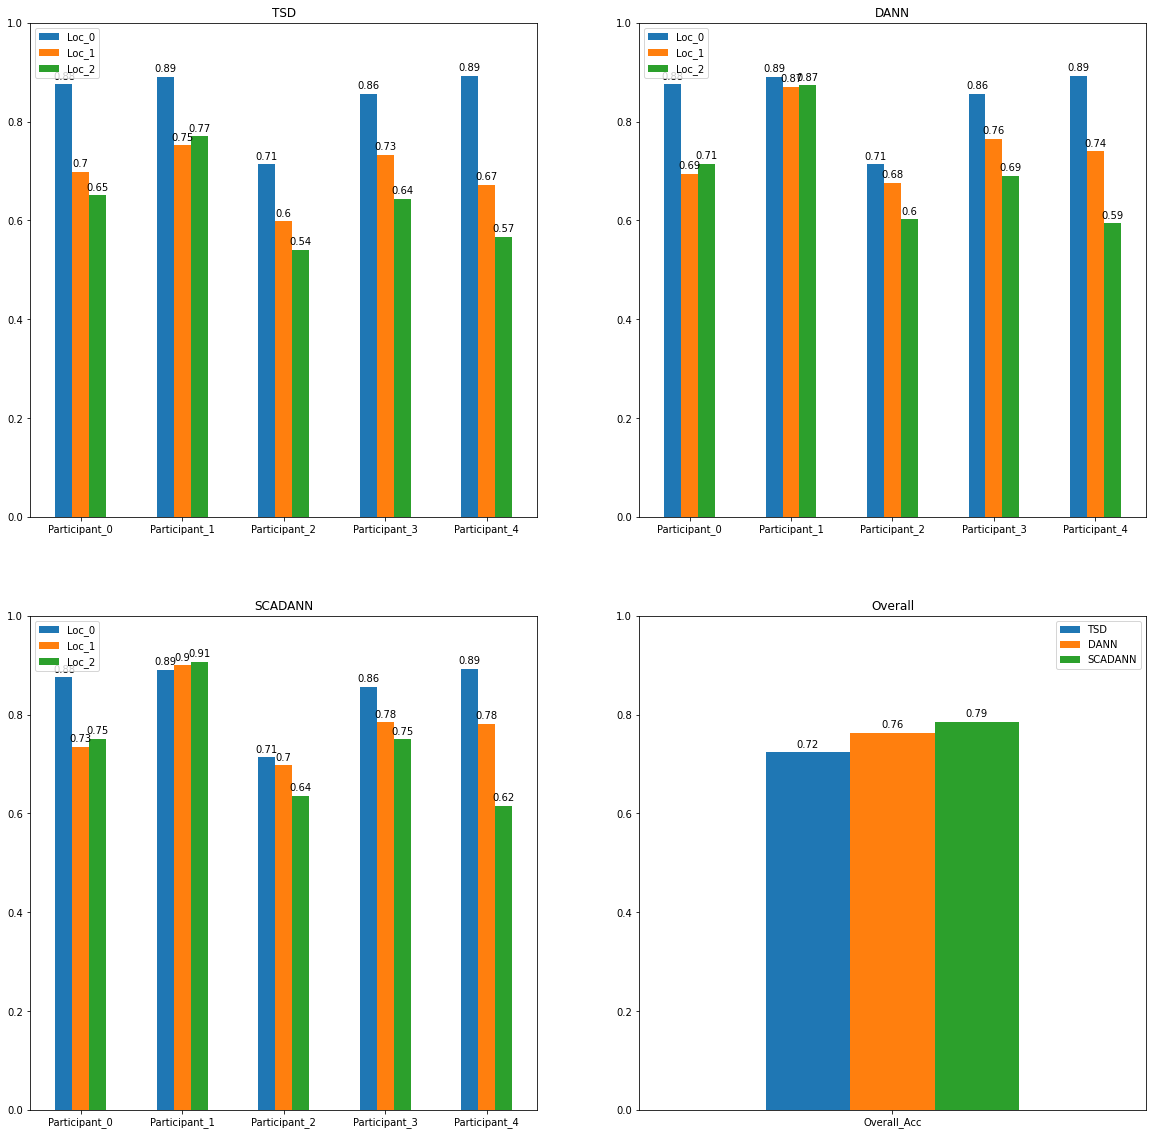

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')

Looking only at the average accuracy of individual participants among all sessions above, both overall and individual accuracies are increasing (the overall accuracy increases from 72% to 79%), so SCADANN is feasible in improving accuracy when trained across wearing locations. The overall acurracy for across location training is generally better than other cases. Though wearing location is to decrease the model performance, it has less effect than other controlling factor such as subjects and days.